<a href="https://colab.research.google.com/github/lukmanaj/brain-tumor-autosegmentation-for-mri-with-unet/blob/main/Unet_architecture_and_impact_on_the_computer_vision_community.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The U-Net paper, titled "U-Net: Convolutional Networks for Biomedical Image Segmentation," was authored by Olaf Ronneberger, Philipp Fischer, and Thomas Brox. It was published in 2015 and has since become a fundamental architecture in the field of computer vision, particularly for tasks like image segmentation. The paper's contributions have revolutionized computer vision by introducing an innovative and efficient way to perform pixel-level segmentation, which is crucial in tasks such as medical image analysis and object detection.

Here's a breakdown of the U-Net paper and its revolutionary impact:

- Motivation and Problem Statement:
The paper's primary focus was on biomedical image segmentation, where the goal is to assign each pixel in an image to a specific class or category. Traditional approaches at the time relied heavily on handcrafted features and often struggled with accurately capturing fine details and object boundaries.

- Architecture Overview:
The U-Net architecture is shaped like a "U," which gives it its name. It consists of two main parts: the contracting path (left side of the U) and the expansive path (right side of the U).

- Contracting Path: This part resembles a typical convolutional neural network (CNN) architecture with several convolutional and pooling layers. These layers progressively reduce the spatial dimensions of the input image while increasing the number of feature channels. This process allows the network to learn hierarchical features from the input image.

- Expansive Path: This part involves up-sampling the learned features using transpose convolutions (also known as deconvolutions or up-convolutions). The up-sampled features are then concatenated with the corresponding features from the contracting path. This skip connection mechanism enables the network to combine high-level contextual information from the contracting path with detailed spatial information from the expansive path.

- Skip Connections:
The use of skip connections is a crucial innovation introduced by U-Net. These connections help to alleviate the information loss that can occur during down-sampling and up-sampling processes. By combining features from different scales of the network, U-Net can make more accurate predictions, especially for capturing fine details and object boundaries.

- Loss Function:
The authors used a pixel-wise cross-entropy loss function to measure the discrepancy between the predicted segmentation and the ground truth. This loss function penalizes misclassifications on a per-pixel basis, allowing the network to learn accurate pixel-level predictions.

- Data Augmentation:
The paper emphasized the importance of data augmentation to increase the robustness of the network. Techniques like random cropping, elastic deformations, and rotations were applied to artificially increase the diversity of the training data.

- Revolutionizing Impact:
The U-Net architecture's revolutionary impact on computer vision can be attributed to several key factors:

- Efficient Semantic Segmentation:
U-Net introduced a highly effective and efficient architecture for semantic segmentation tasks. Its ability to capture both global context and fine details through skip connections made it particularly well-suited for tasks where accurate object boundaries and details matter.

- Skip Connections and Multi-scale Information:
The skip connections allowed U-Net to integrate multi-scale information into its predictions. This innovation significantly improved the accuracy of segmentation results compared to traditional CNN architectures.

- State-of-the-Art Performance:
U-Net quickly gained popularity due to its outstanding performance on various biomedical image segmentation tasks. It consistently outperformed existing methods and set new benchmarks in terms of accuracy.

- Broad Applicability:
While initially developed for biomedical image segmentation, the U-Net architecture's principles have been widely adopted and adapted for various computer vision tasks beyond medical imaging, such as natural scene segmentation, satellite image analysis, and more.

In summary, the U-Net paper's introduction of skip connections, its efficient architecture, and its impressive performance in biomedical image segmentation played a pivotal role in revolutionizing computer vision by providing a powerful and adaptable framework for accurate and detailed image segmentation tasks.

Below, we'll look at an implementation of the unet paper using Pytorch.


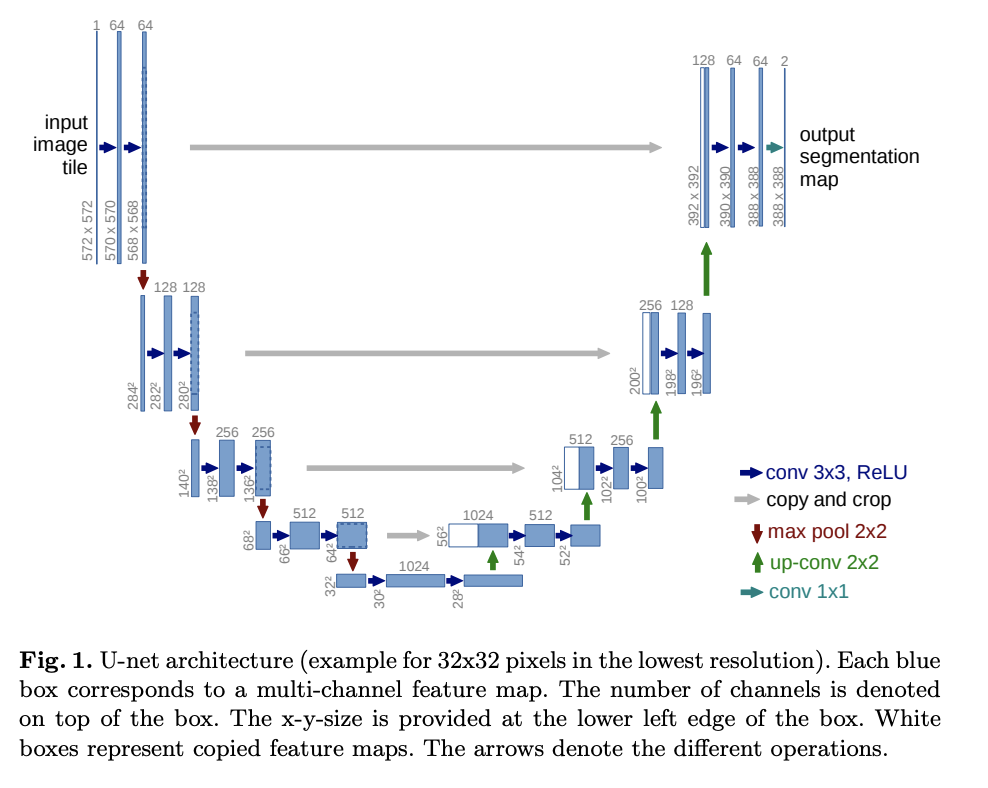

In [ ]:
import torch
import torchvision.transforms.functional
from torch import nn


The only difference is that in this implementation, padding will be used to avoid cropping the final feature map.



In [ ]:
class DoubleConvolution(nn.Module):
  '''Each step in the contraction path and expansive path have two 3×3 convolutional layers followed by ReLU activations.
'''
  def __init__(self,in_channels:int,out_channels:int):
    super.__init__()
    self.first = nn.Conv2d(in_channesls,out_channels,kernel_size=3,padding= 1)
    self.act1 = nn.ReLU()
    self.second = nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1)
    self.act2 = nn.ReLU()

    def forward(self,x:torch.Tensor):
      # Apply the two convolution layers and activations
      x = self.first(x)
      x = self.act1(x)
      x = self.second(x)
      return self.act2(x)




In [ ]:
class Downsample(nn.Module):
  # Each step in the contracting path down-samples the feature map with a 2×2 max pooling layer.
  def __init__(self):
    super.__init__()
    # max pooling layer
    self.pool = nn.MaxPool2d(2)

  def forward(self,x:torch.Tensor):
    return self.pool(x)


In [ ]:
class Upsample(nn.Module):
  # Each step in the expansive path up-samples the feature map with a 2×2 up-convolution.
  def __init__(self,in_channels:int,out_channels:int):
    super.__init__()
    # up convolution
    self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

  def forward(self,x:torch.Tensor):
    return self.up(x)

In [ ]:
class CropAndConcat(nn.Module):
  # At every step in the expansive path the corresponding feature map from the contracting path is concatenated with the current feature map.
  def forward(self, x: torch.Tensor, contracting_x: torch.Tensor):
    # Crop the feature map from the contracting path to the size of the current feature map
    contracting_x = torchvision.transforms.functional.center_crop(contracting_x, [x.shape[2], x.shape[3]])
    # Concatenate the feature maps
    x = torch.cat([x, contracting_x], dim=1)
    return x


# U-Net


In [ ]:
class UNet(nn.Module):
  def __init__(self,in_channels: int,out_channels: int):
    super().__init()
    # Double convolution layers for the contracting path. The number of features gets doubled at each step starting from 64.
    self.down_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(in_channels, 64), (64, 128), (128, 256), (256, 512)]])
    # Down sampling layers for the contracting path
    self.down_sample = nn.ModuleList([DownSample() for _ in range(4)])
    # The two convolution layers at the lowest resolution (the bottom of the U).
    self.middle_conv = DoubleConvolution(512, 1024)
    # Up sampling layers for the expansive path. The number of features is halved with up-sampling.
    self.up_sample = nn.ModuleList([UpSample(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]])
    # Double convolution layers for the expansive path. Their input is the concatenation of the current feature map and the feature map from the contracting path.
    # Therefore, the number of input features is double the number of features from up-sampling.
    self.up_conv = nn.ModuleList([DoubleConvolution(i, o) for i, o in [(1024, 512), (512, 256), (256, 128), (128, 64)]])
    # Crop and concatenate layers for the expansive path.
    self.concat = nn.ModuleList([CropAndConcat() for _ in range(4)])
     #   Final 1×1 convolution layer to produce the output
    self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor):
      # To collect the outputs of contracting path for later concatenation with the expansive path.
      pass_through = []
      # contracting path
      for i in range(len(self.down_conv)):
        # Two 3×3 convolutional layers
        # afford
         x = self.down_conv[i](x)
         # collect the output
         pass_through.append(X)
         # Down-sample
         x = self.down_sample[i](x)
         # Two 3×3 convolutional layers at the bottom of the U-Net
      x = self.middle_conv(x)
      for i in range(len(self.up_conv)):
        x = self.up_sample[i](x)

     # Concatenate the output of the contracting path

        x = self.concat[i](x, pass_through.pop())

       # Two 3×3 convolutional layers
        x = self.up_conv[i](x)
        # Final 1×1 convolution layer

        x = self.final_conv(x)
    return x


